# Adaptive Intelligence Assignment 1


I provide here an Python implementation of the neural network described in the assignment.
This code is an extension of the code provided in the lab week 2 of the module, therefore, a major part of the credit goes to this implementation. 

In [13]:
import numpy as np;
import random
import numpy.matlib 
import math
import matplotlib.pyplot as plt
import csv
import pandas as pd;
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

In [14]:
# Load the EMNIST dataset.
# REF : Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). 
# EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373
# Here the EMNIST data has been modified so the size is 1000 samples per class for training
# and 250 per class for testing

from scipy.io import loadmat

emnist = loadmat('emnist-letters-1k.mat')

# Read the train set
x_train = emnist['train_images']
# Read the train labels
trainlabels = emnist['train_labels']

# Read the test set
x_test = emnist['test_images']
# Read the test labels
testlabels = emnist['test_labels']

# Randomise Test set
X_test, test_labels = shuffle(x_test, testlabels)

# Apply the split between Train and Validation sets (Randomly selected from 20% of Training Set)
X_train, X_validation, train_labels, validation_labels = train_test_split(
    x_train, trainlabels, test_size = 0.2, random_state = None) 

# Normalise the Sets
NX_train = preprocessing.normalize(X_train)
NX_test = preprocessing.normalize(X_test)
NX_validation = preprocessing.normalize(X_validation)

# Show the shape of each of these arrays
# Our convention is for the first dimension to be the number of samples
print("Training Samples * (28*28) =", NX_train.shape)
print("Training Labels", train_labels.shape)

print("Testing Samples * (28*28) =", NX_test.shape)
print("Testing Labels ", test_labels.shape)

print("Validation Samples * (28*28) =", NX_validation.shape)
print("Validation Labels ", validation_labels.shape)
n_samples, img_size = NX_train.shape

# The EMNIST contains letters from A to Z so we will set the number of labels as 26
nlabels = 26

Training Samples * (28*28) = (20800, 784)
Training Labels (20800, 1)
Testing Samples * (28*28) = (6500, 784)
Testing Labels  (6500, 1)
Validation Samples * (28*28) = (5200, 784)
Validation Labels  (5200, 1)


In [15]:
# Perform One-Hot Enconding

y_train = np.zeros((train_labels.shape[0], nlabels))
y_test  = np.zeros((test_labels.shape[0], nlabels))
y_validation = np.zeros((validation_labels.shape[0], nlabels))

for i in range(0,train_labels.shape[0]):   
    y_train[i, train_labels[i].astype(int)]=1
    
for i in range(0,test_labels.shape[0]):    
    y_test[i, test_labels[i].astype(int)]=1
    
for i in range(0,validation_labels.shape[0]):
    y_validation[i, validation_labels[i].astype(int)]=1

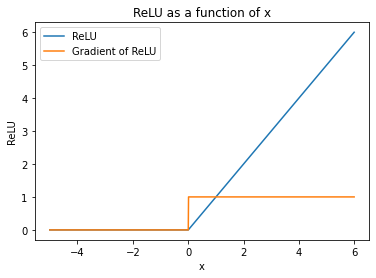

In [16]:
# ReLU Function
def ReLU(x):
    return max(0, x)

def Der_ReLU(x):
    return np.greater(x, 0).astype(int)

# Plot ReLU Function
x = np.arange(-5, 6, 0.01)
y = [ReLU(x) for x in x]
y2 =[Der_ReLU(x) for x in x]

plt.plot(x, y, label='ReLU')
plt.plot(x, y2, label='Gradient of ReLU')
plt.xlabel('x')
plt.ylabel('ReLU')
plt.title('ReLU as a function of x')
plt.legend()
plt.show()

# The derivative of ReLU is :
# ReLU'(x) = 0 if x < 0
# ReLU'(x) = 1 if x > 0
# Not defined if x = 0

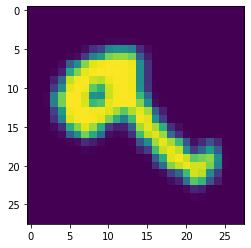

[16]


In [17]:
# Example of image, take the transpose to see it in the right orientation
example_image = np.reshape(NX_validation[332], (28, 28))
plt.imshow(example_image.T)
plt.show()
print(validation_labels[332])

In [18]:
# define constants
n_epoch = 250 # 100 ?
batch_size = 50
n_batches = int(math.ceil(n_samples/batch_size))

# define the size of each of the layers in the network
n_input_layer  = img_size
n_output_layer = nlabels

# eta is the learning rate
eta = 0.3
r = 0.01
lam = 0.00003

In [19]:
def get_validation_score(test_set, W1, bias_W1, labels):
    n = test_set.shape[0]

    p_ra = 0
    correct_value = np.zeros((n,))
    predicted_value = np.zeros((n,))

    for i in range(0, n):
        x0 = test_set[i]
        y = labels[i]
        
        dot_pro = np.dot(W1, x0) + bias_W1
        act_out = np.maximum(0, dot_pro)

        correct_value[i] = np.argmax(y)

        predicted_value[i] = np.argmax(act_out)

        if predicted_value[i] == correct_value[i]: 
            p_ra = (p_ra + 1)

    accuracy = 100*p_ra/n 
    return accuracy

In [20]:
# Kaiming or He Initialization Strategy

# W1: Number of columns (input) needs to be equal to the number of features 
#     of the  EMNIST letters, thus p. Number of rows (output) should be equal 
#     to the number of neurons of the hidden layer thus n_hidden_layer.

W1 = np.random.randn(n_output_layer, n_input_layer) * np.sqrt(2 / (n_input_layer))
print(W1.shape)

(26, 784)


In [21]:
# Initialize the biases
bias_W1 = np.zeros((n_output_layer,))

In [22]:
# Keep track of the network inputs and average error per epoch
errors = np.zeros((n_epoch,))
weight_updates = np.zeros((n_epoch,))

In [23]:
def der_l1_pen(a):
    a = np.where(a > 0, 1, a)
    a = np.where(a <= 0, -1, a)
    return a

b = np.array([-1, 2, 4, -5, 0, -4, 5 , 6, 10, 11])
print(der_l1_pen(b))
print(np.sum(der_l1_pen(b)))
print(lam * der_l1_pen(b))

[-1  1  1 -1 -1 -1  1  1  1  1]
2
[-3.e-05  3.e-05  3.e-05 -3.e-05 -3.e-05 -3.e-05  3.e-05  3.e-05  3.e-05
  3.e-05]


In [24]:
# Let's train the network

for i in range(0, n_epoch):
    
    # Initialise the gradients for each batch
    dW1 = np.zeros(W1.shape)
    
    # We will shuffle the order of the samples each epoch
    shuffled_idxs = np.random.permutation(n_samples)
    
    for batch in range(0,n_batches):
        # Initialise the gradients for each batch
        dW1 = np.zeros(W1.shape)
        # Bias vector
        dbias_W1 = np.zeros(bias_W1.shape)
            
        # Loop over all the samples in the batch
        for j in range(0,batch_size):

            # Input (random element from the dataset)
            idx = shuffled_idxs[batch*batch_size + j]
            x0 = NX_train[idx]
            
            # Form the desired output, the correct neuron should have 1 the rest 0
            desired_output = y_train[idx]

            # Neural activation: input layer -> output layer
            h1 = np.dot(W1,x0)+bias_W1

            # Apply the ReLU function
            x1 = np.maximum(0, h1)

            # Compute the error signal
            e_n = desired_output - x1
            
            # Compute the L1 penalty error
            #s_l1 = lam * np.sum(np.absolute(dW1))
            #d_l1 = lam * der_l1_pen(dW1)
            
            # Backpropagation: output layer -> input layer
            delta1 = Der_ReLU(x1) * e_n 
            
            dW1 += np.outer(delta1,x0) #- d_l1
            dbias_W1 += delta1
            
            # Store the error, score per epoch
            errors[i] = errors[i] + 0.5 * np.sum(np.square(e_n)) / n_samples 
        
        if i == 0 :
                weight_updates[i] = np.sum(np.absolute(dW1)) 
                average_matrix = dW1
        else:
                weight_updates[i] = np.sum(np.absolute(average_matrix * (1-r) + r*(dW1))) 
                average_matrix = (average_matrix * (1-r) + r*(dW1))
        
                
        # After each batch update the weights using accumulated gradients
        W1 += eta*dW1 / batch_size 
        bias_W1 += eta*dbias_W1/batch_size
                
    print( "Epoch ", i+1, ": error = ", errors[i], ": Sum(A) = ", weight_updates[i])

Epoch  1 : error =  0.42296566406406727 : Sum(A) =  420.5115579510072
Epoch  2 : error =  0.3631041747202164 : Sum(A) =  63.564696586047546
Epoch  3 : error =  0.34061301345174544 : Sum(A) =  50.387354983684524


KeyboardInterrupt: 

In [ ]:
# Plot the performance
plt.plot(errors)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Average error per epoch')
plt.show()

In [ ]:
# Plot the performance
plt.plot(weight_updates)
plt.xlabel('Epoch')
plt.ylabel('Weight Updates')
plt.title('Weight Updates per epoch')
plt.show()

In [ ]:
# TODO: use the test set to compute the network's accuracy
n = NX_test.shape[0]

p_ra = 0
correct_value = np.zeros((n,))
predicted_value = np.zeros((n,))

for i in range(0, n):
    x0 = NX_test[i]
    y = y_test[i]
    
    correct_value[i] = np.argmax(y)
    
    h1 = np.dot(W1, x0) + bias_W1
    x1 = np.maximum(0, h1)
    
    predicted_value[i] = np.argmax(x1)
            
    if predicted_value[i] == correct_value[i]: 
        p_ra = (p_ra + 1)

accuracy = 100*p_ra/n 
print("Accuracy = ", accuracy)

In [ ]:
# TODO: use the test set to compute the network's accuracy
n = NX_validation.shape[0]

p_ra = 0
correct_value = np.zeros((n,))
predicted_value = np.zeros((n,))

for i in range(0, n):
    x0 = NX_validation[i]
    y = y_validation[i]
    
    correct_value[i] = np.argmax(y)
    
    h1 = np.dot(W1, x0) + bias_W1
    x1 = np.maximum(0, h1)
    
    predicted_value[i] = np.argmax(x1)
            
    if predicted_value[i] == correct_value[i]: 
        p_ra = (p_ra + 1)

accuracy = 100*p_ra/n 
print("Accuracy = ", accuracy)